In [32]:
pip install -q 'gwosc==0.7.1'

In [33]:
pip install -q pycbc

In [34]:
pip install -q 'gwpy==3.0.12'

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower, interpolate, inverse_spectrum_truncation
from pycbc.noise import noise_from_psd
from pycbc.types import TimeSeries
from pycbc.filter import matched_filter, sigma, resample_to_delta_t, highpass
from pycbc.psd import welch

In [36]:
sample_rate = 2048
delta_t = 1.0 / sample_rate
data_length = 8 # seconds
flen = int(sample_rate / (2 * (1.0 / data_length))) + 1
flow = 20.0

PSD tells how the power of timeseries signal is distributed across diffrent frequencies.
<br>
the arguments are:-<br>
flen= Length of PSD
1/delta_length= frequency
flow= lower frequency cutoff (PSD is 0 below this)



In [37]:
psd = aLIGOZeroDetHighPower(flen, 1.0 / data_length, flow)

This plot shows PSD at frequencies lower frequency(10-30) have high PSD which shows the data is very noisy around it . <br>
And around 30 -300 the PSD is low means this is sensitive range and signal can be detected easily.

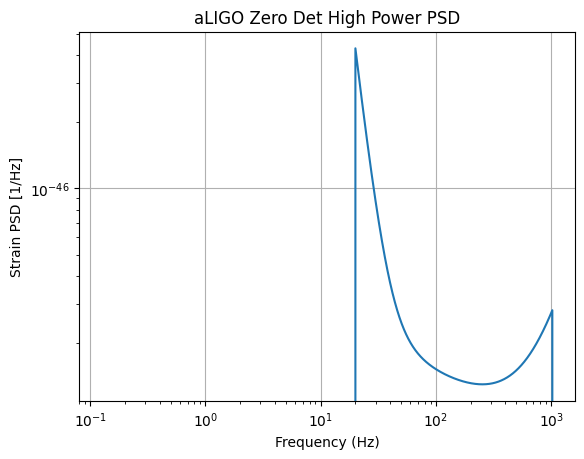

In [38]:
import matplotlib.pyplot as plt
plt.loglog(psd.sample_frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain PSD [1/Hz]')
plt.title('aLIGO Zero Det High Power PSD')
plt.grid()
plt.show()


noise_from_psd generate noise from the psd defined above.<br>
this function genrate the white noise in frequency domain than multipy it with PSD given to make it colored than again converted to timeseries using fft.
<br>
sample_rate \* data_length gives the total no. of samples<br>
same seed value will produce the same sequence of random numbers each time the code is executed

---

resample_to_delta_t ensures that the noise is from delta_t time


In [39]:
# Generate colored noise
noise = noise_from_psd(sample_rate * data_length, delta_t, psd, seed=123)
noise = resample_to_delta_t(noise, delta_t)


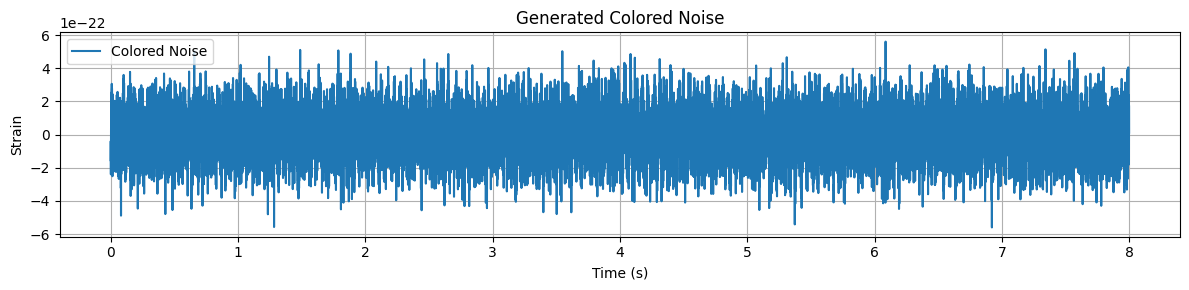

In [40]:
plt.figure(figsize=(12, 3))
plt.plot(noise.sample_times, noise, label='Colored Noise')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Generated Colored Noise")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

##Why to estimate PSD?<br>
In real data we don't konw the PSD that genrated the noise so we estimate it from the data using Welch method (average of FFTs of segments).<br>
using formula :- PSD(f)=⟨∣$\tilde{x}$(f)∣ \*\*2⟩
<br>
where:-<br>
x(t) is time domain strain data <br>
$\tilde{x}$(f) is fourier transform of x(t)<br>
∣$\tilde{x}$(f)∣ \*\*2 is power at each frequency<br>
and <> means average this over multple segment of data.


---
in Welch method we take the segments of data<br>
than perform FFT on each segment <br>
than square the magnitude <br>
than take average across segments to estimate PSD.<br>
<br>
here we are using noise.psd(4) to apply the welch method which takes 4 seconds of each segment(means 2 segments for 8 sec ) <br>
in back side noise.psd() is using folowing function to estimate psd(given in documentation to estimate psd)
estimated_psd = pycbc.psd.welch(ts,
                      seg_len=seg_len,
                      seg_stride=seg_stride)<br>
but noise.psd() automatically take parameter like sample rate and delta_t

---
In psd_est = interpolate(psd_est, noise.delta_f) we resample the PSD so that its frequency matches that of time domain data<br>
the frequency of psd_est could be diffrent from the orginal data frequency so it matches the frequency by adding the middele values of frequency which are missing.


---

In psd_est = inverse_spectrum_truncation(psd_est, int(4 * noise.sample_rate), low_frequency_cutoff=15) <br>
during whitening of data we neet to divide the signal with root of PSD so if PSD is very small the x(f) will be very high .<br>
so this functon supress low frequency region.




In [71]:
psd_est = noise.psd(4)
psd_est = interpolate(psd_est, noise.delta_f)
psd_est = inverse_spectrum_truncation(psd_est, int(4 * noise.sample_rate), low_frequency_cutoff=20)

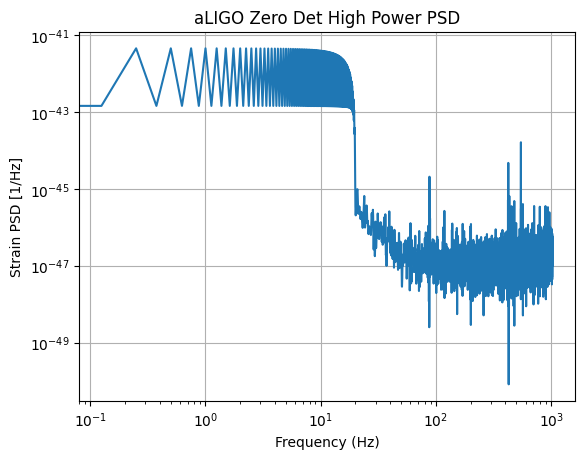

In [72]:
plt.loglog(psd_est.sample_frequencies, psd_est)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain PSD [1/Hz]')
plt.title('aLIGO Zero Det High Power PSD')
plt.grid()
plt.show()

In [42]:
segment_duration = 4  # in seconds
seg_len = int(segment_duration * noise.sample_rate)  # 4s segments
seg_stride = int(seg_len * 0.5)
psd_est = welch(noise, seg_len=seg_len, seg_stride=seg_stride, avg_method='median')
psd_est = interpolate(psd_est, noise.delta_f)
psd_est = inverse_spectrum_truncation(psd_est, int( noise.sample_rate), low_frequency_cutoff=30)

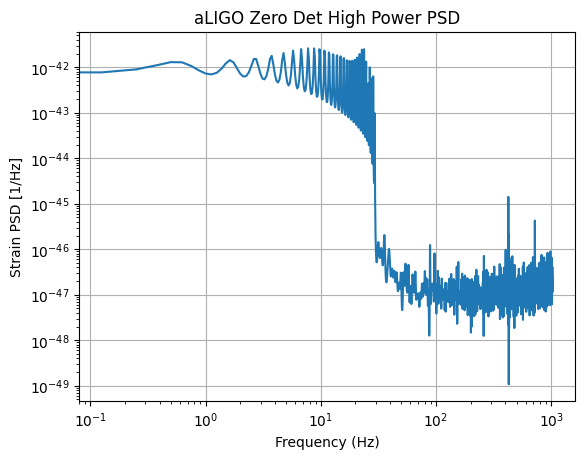

In [43]:
import matplotlib.pyplot as plt
plt.loglog(psd_est.sample_frequencies, psd_est)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain PSD [1/Hz]')
plt.title('aLIGO Zero Det High Power PSD')
plt.grid()
plt.show()

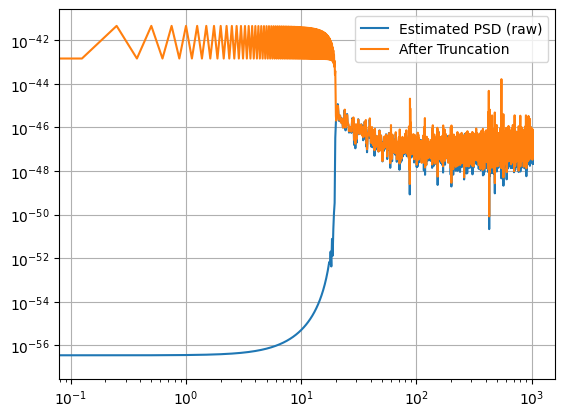

In [57]:
psd_est_raw = welch(noise, seg_len=seg_len, seg_stride=seg_stride, avg_method='median')
plt.loglog(psd_est_raw.sample_frequencies, psd_est_raw, label='Estimated PSD (raw)')
psd_est = interpolate(psd_est_raw, noise.delta_f)
psd_est_trunc = inverse_spectrum_truncation(psd_est, int(4*noise.sample_rate), low_frequency_cutoff=20)
plt.loglog(psd_est_trunc.sample_frequencies, psd_est_trunc, label='After Truncation')
plt.legend()
plt.grid()
plt.show()

In [58]:
mass = 36  # Solar masses
hp, _ = get_td_waveform(approximant="SEOBNRv4", mass1=mass, mass2=mass,
                        delta_t=noise.delta_t, f_lower=flow)
norm_factor = np.sqrt(abs(float((hp * hp.conj()).sum() * hp.delta_t)))
hp = hp / norm_factor * 1e-22
hp.resize(len(noise))

In [59]:
# Inject signal into noise
injection_time = 2.0
injection_index = int(injection_time / delta_t)
signal = hp   # scale to realistic strain
injected_data = noise.copy()

if injection_index + len(signal) > len(injected_data):
    signal = signal[:len(injected_data) - injection_index]
injected_data[injection_index:injection_index + len(signal)] += signal.numpy()

In [60]:
template = hp.cyclic_time_shift(hp.start_time)

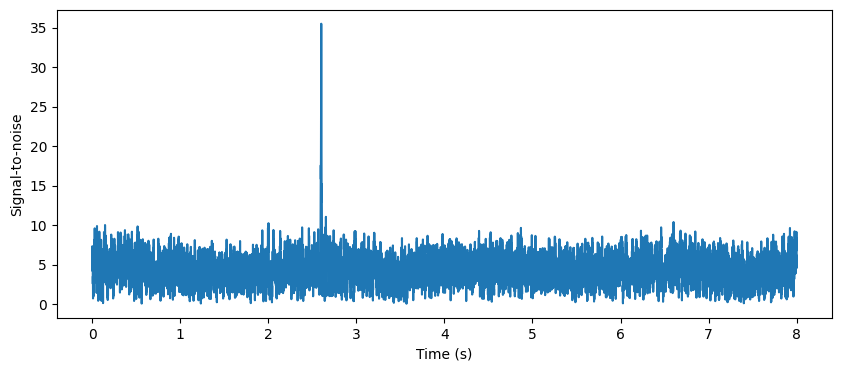

In [61]:
snr = matched_filter(template, injected_data, psd=psd_est, low_frequency_cutoff=flow)
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

In [62]:
peak = abs(snr).numpy().argmax() #convert the snr to magnitude and find index of maximum snr
snrp = snr[peak] #value at snr peak
time = snr.sample_times[peak] #time corresponding to peak time
dt = time - injected_data.start_time #compute time shift for template
aligned = template.cyclic_time_shift(dt) #shift the template by dt  aligns the waveform in time to match where the signal was found in the data.
aligned /= sigma(aligned, psd=psd_est, low_frequency_cutoff=flow)#Divides the aligned template by that norm
                                                                #This ensures the template has unit norm under the noise model (PSD).
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() #scale template to snrp level
aligned.start_time = injected_data.start_time #Sets the start time of the aligned waveform to match the data.

In [63]:
white_data = (injected_data.to_frequencyseries() / psd_est**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd_est**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

In [64]:
# Time slice around detected signal (±0.2s window)
start_time = max(white_data.start_time, time - 0.5)
end_time = min(white_data.end_time, time + 0.1)

white_data = white_data.time_slice(start_time, end_time)
white_template = white_template.time_slice(start_time, end_time)

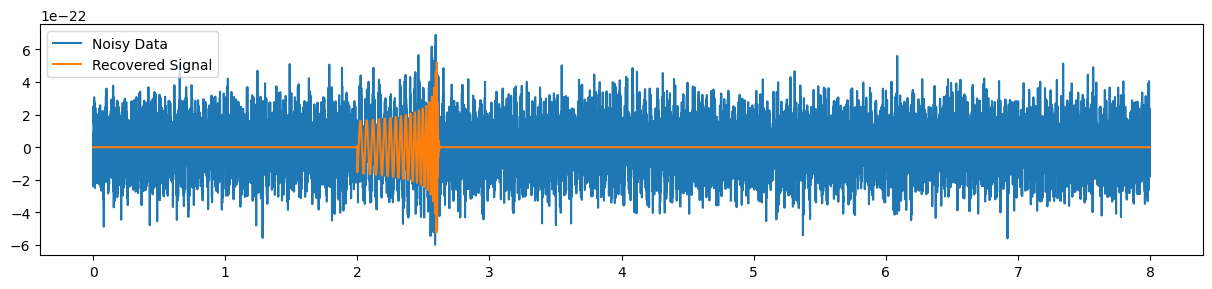

In [65]:
plt.figure(figsize=[15, 3])
plt.plot(injected_data.sample_times, injected_data, label="Noisy Data")
plt.plot(aligned.sample_times, aligned, label="Recovered Signal")
plt.legend()
plt.show()

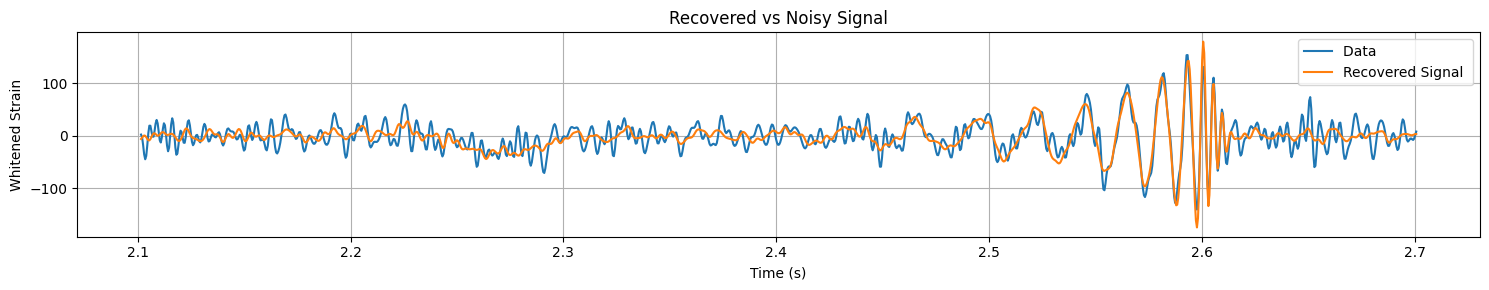

(np.float64(2.6015625), 35.482817819350956)

In [66]:
plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data , label="Data ")
plt.plot(white_template.sample_times, white_template , label="Recovered Signal ")

plt.xlabel("Time (s)")
plt.ylabel("Whitened Strain")
plt.title("Recovered vs Noisy Signal")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Return key metrics for reference
time, float(abs(snrp))